# Lab 2 - Simple Chemotaxis

This lab is designed to get you familiar with the basics of chemotaxis like that performed by bacteria, specifically _e. coli_.  

We will compare our random agent from Lab 1 (Rando) with a gradient searcher who operates akin to a simple bacteria agent. We'll call this agent Chemo.

There are three goals here.

1. Extrapolate on scent signals and gradients.
2. Examine exploration for targets with a variable scent in an open field.
3. Compare simple chemotaxis, with a Levy-walk structure, to Brownian motion.

## Background

In this lab we return to _taxic explorations_. We visit the sniff world (aka _ScentGrid_) and at what happens when sense signals are noisy.


**Structured randomness and basic chemotaxis**

In lab 1 we played with a random search agent that wandered using Brownian motion. Here we will introuce a new random agent that moves according to Levy walks.

* A Levy walk is a continuing process of random movement where at each "step" of movement, a direction of and distance of movement is chosen randomly. The distance $\delta_i$ of movement at each time step $i$ is sampled from the random distribution as follows: $\delta_i = {u_i}^{-\frac{1}{\gamma}}$, where $u_i \sim N(\mu,\sigma)$ and $\gamma > 1$.

Our _chemotaxis_ agent (_GradientDiffusionGrid_) tries to directly estimate the gradient of the scent $\nabla S$  by comparing the level of scent at the last grid position it occupied to the current scent level ($s$). By last position here we mean the last position when it moved last.

$$\nabla S \approx s_t - s_{t-1}$$

Our chemotaxis agent thus behaves as follows:

- When the gradient is positive, meaning you are going "up" the gradient, the probabilty of changing course and doing a tumble is set to _p pos_.
- When the gradient is negative, the probability of a doing a tumble is set to _p neg_. (See code below, for an example).
- If the agent "decides" to tumble, the direction it takes is uniform random.
- If no tumble is decided, the agent keeps moving in the direciton it was going before.
- The length of travel now is just a single step on the grid. This makes our decision problem a lot simpler. Basically this is equivalent to making the diffusion parameter, $D$, consistent across experiments.


## Section 0 - Setup

First let's set things up for the two parts of the lab. You've done this before, so we don't need to specify each installation and module step.

In [1]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-zditd2ga
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-zditd2ga
  Resolved https://github.com/coaxlab/explorationlib to commit 1370823ba06ddf3a3b14929e3de0cb4d16b7ce49
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42722 sha256=750f6e360a5c6009990e3184550dcd42fd1ea875733fe3100b5b450fb6d6d461
  Stored in directory: /tmp/pip-ephem-wheel-cache-g60s4x6j/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-3sfffnob
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-3sfffnob
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

In [2]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid


from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - Simulating noisy scents

To build some intuition, let's plot the "scent" emitted by a single target.

### Full Scent

Okay, let's first visualize what the scent diffusion around each target looks like in the environment using the diffusion parameters we have set up.

In [4]:
target_boundary = (10, 10)

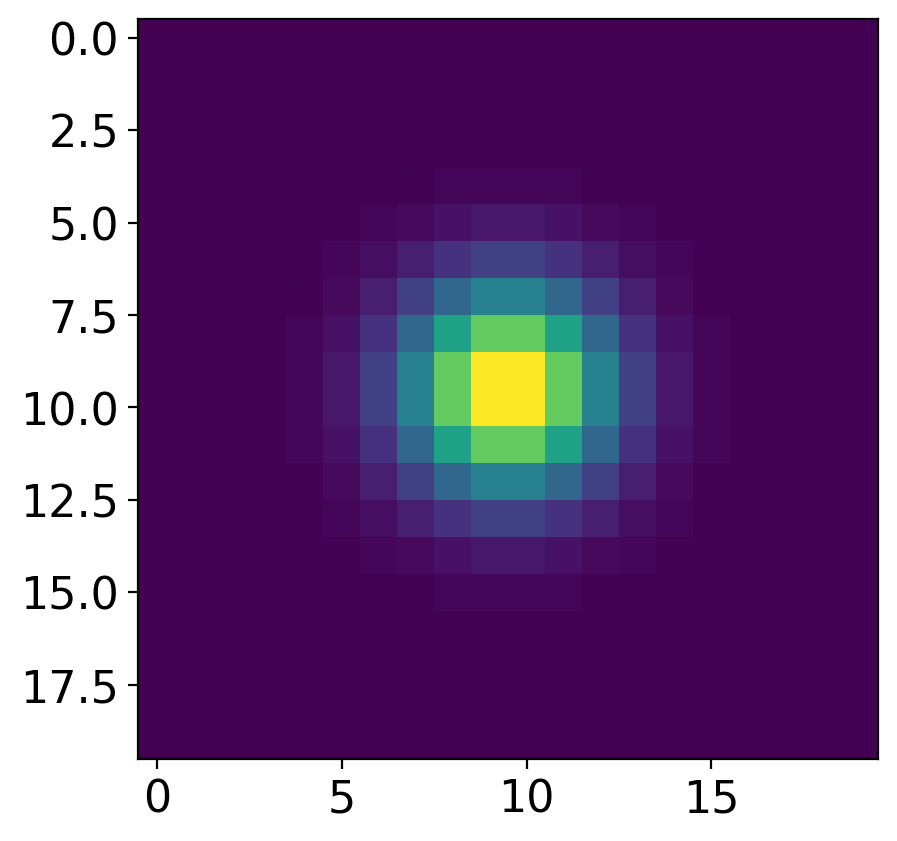

In [5]:
coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, sigma=2)

plt.imshow(scent, interpolation=None)

### Noisy Scent

To corrupt the signal we can simply add more Gaussian noise. In this case we will use the *add_noise* function with a $\sigma=1$.

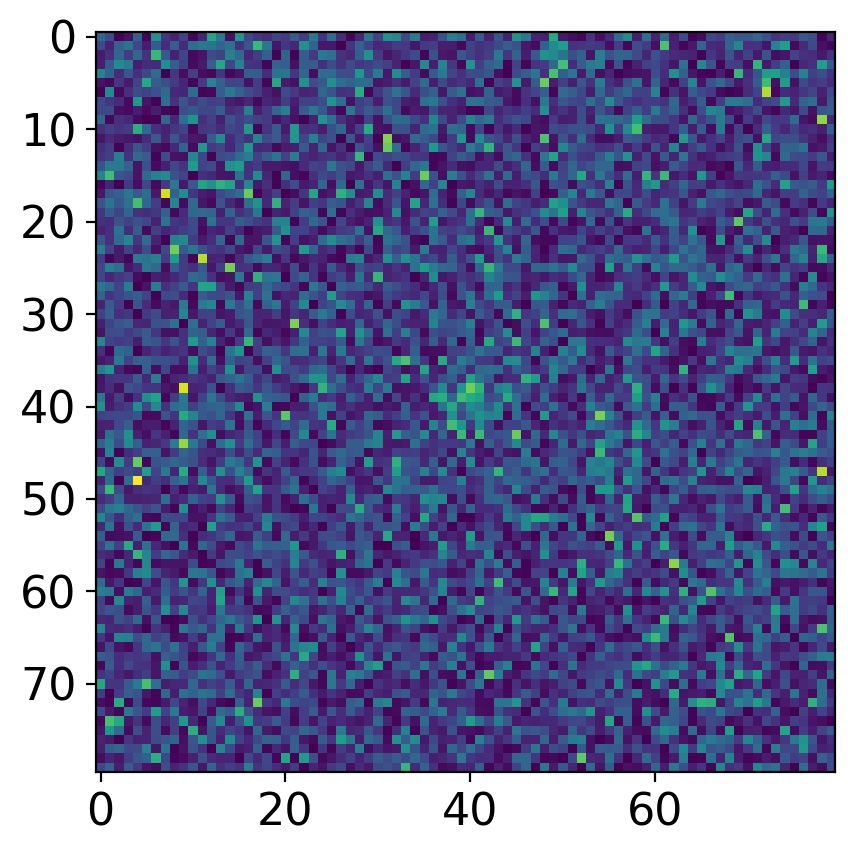

In [45]:
noise_sigma = 1.0

coord, scent = create_grid_scent_patches(target_boundary, p=1.0, sigma=2)
scent = add_noise(scent, noise_sigma)

plt.imshow(scent, interpolation=None)

Doesn't look resolvable does it? If you squint, maybe you can see it?

In order to confirm that there is signal there, let's take a look at the average over 100 noisy targets.

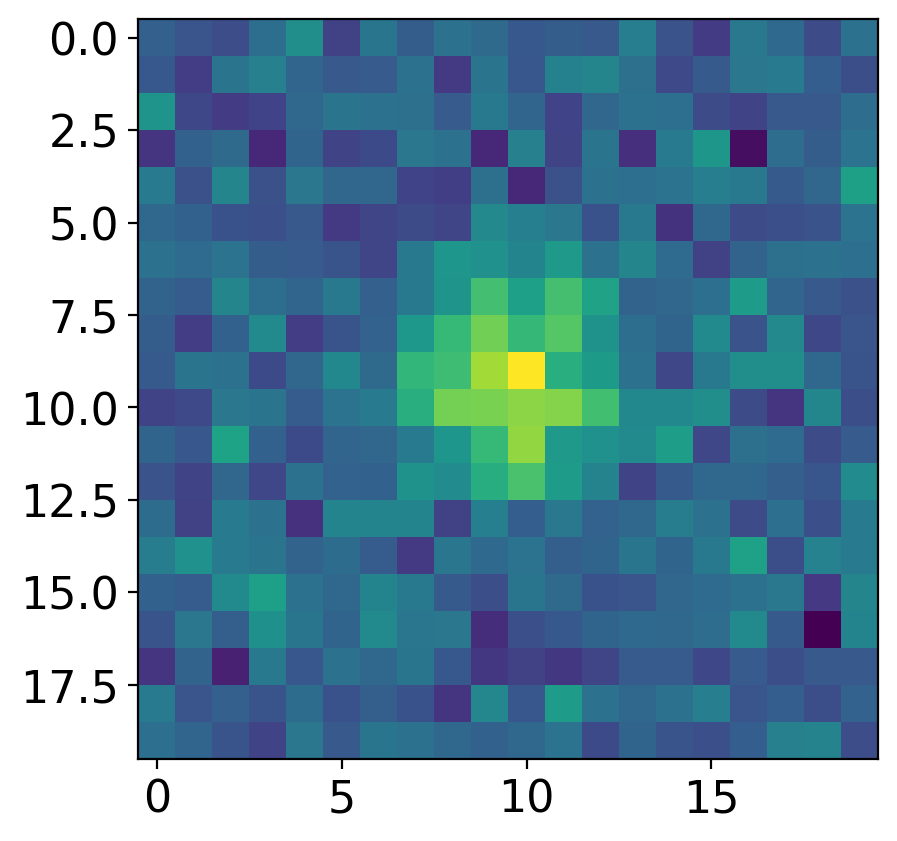

In [17]:
amplitude = 1
noise_sigma = 8.0
num_samples = 1000

scents = []
for _ in range(num_samples):
    coord, scent = create_grid_scent_patches(target_boundary, p=1.0, sigma=2)
    scent = add_noise(scent, noise_sigma)
    scents.append(deepcopy(scent))

scent = np.sum(scents, axis=0)

plt.imshow(scent, interpolation=None)

So, pretty noisy but resolvable.

---
### Question 1.1

Adding noise and lowering detection probability both act to increase distortion to the signal channel that will be used by our agents. Will this help or hinder the agents that use sensory signals and/or information to drive their decisions? Explain your answer.

__Answer:__

This hinders the ability to detect the signal, because the distortion of the signal channel will cause the agent to go in multiple directions that may not be along the right path to reach the target.

---
### Question 1.2

Re-run the simulations above, playing with the *noise_sigma* term, ranging from 1 to 10. What are the values for each parameter that lead to a complete loss in the scent signal (first plot) and how does it change what you can resolve when averaging across 1000 samples?

__Answer:__

In the first plot, the signal is already completely lost at a noise sigma around 2.0. In the second plot, at a noise sigma of 8.0, there is a complete lost in the scent signal. When you average across 1000 samples, there is less noise and it is easier to detect the signal.

## Section 2 - Using Basic Sensory Evidence To Explore


In this section we take on the simplest form of sensory tracking: whether or not a chemical gradient is increasing or decreasing.

We start by setting up our basic environment.

In [18]:
# Noise scents
noise_sigma = 2 # We'll make it pretty noisy

# Shared
num_experiments = 100
num_steps = 500
seed_value = 5838

# ! (leave alone)
min_length = 1
num_targets = 50
target_boundary = (40, 40)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Again we are working a scent grid environment where each target emits noisy chemical signals (scents) according to our definitions above.

We will want the environment to be relatively sparse, to make the task somewhat difficult. Thus we will only generate 25 targets in a big open field.

Here's an example of our environment

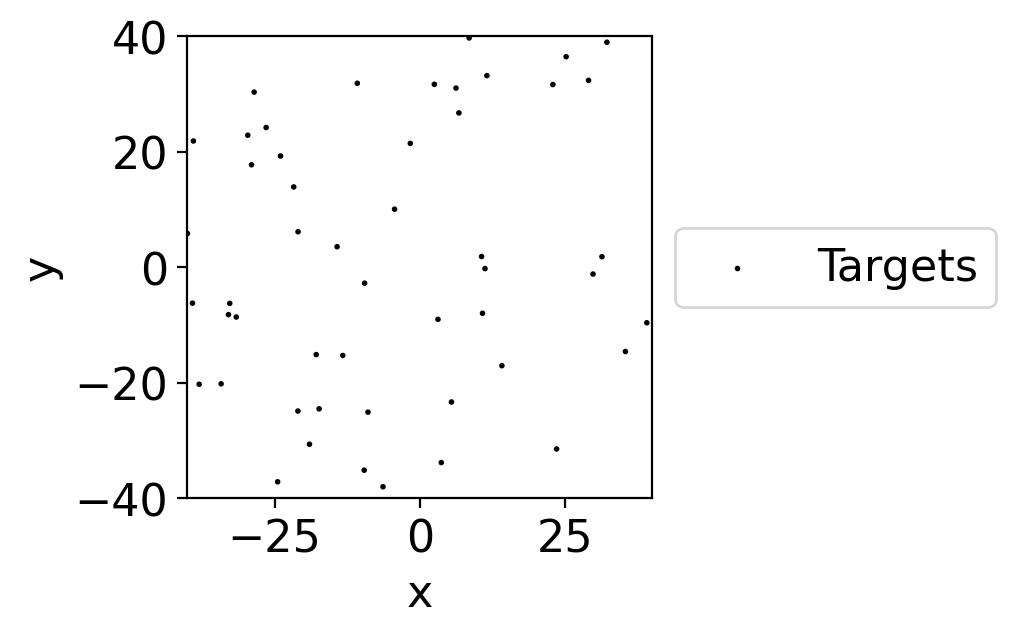

In [19]:
plot_boundary = target_boundary
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

We will use 2 agents in these sims:

- Rando: Uses random Brownian motion search.
- Chemo: Uses only the detected scent gradient to make a decision as to whether or not to tumble.

How do these agents work? Check the explorationlib code for details.

* In the left panel on Colab, click on the file icon to access the file view for your Colab notebook.
* Click the ".." file to go up one level (if necessary) and then navigate to `/usr/local/lib/python3.XX/dist-packages/explorationlib/agent.py` and double click the file (or just click the link in this bullet) to open up the library's code for defining exploration agents.
* Find the _DiffusionGrid_ and _GradientDiffusionGrid_ functions to see how they are implemented.

In [54]:
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length)
diff.seed(seed_value)

# Chemotaxis agent
min_length = 1 # Minimum step length on the grid
p_neg = 1.0 # Probability of jumping if gradient is decreasing
p_pos = 0.0 # Probabilty of jumping if gradient is increasing
chemo = GradientDiffusionGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
)
chemo.seed(seed_value)


[5838]

Now let's run the experiments.

In [55]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot an example experiment. Here I'm choosing the second run for each agent.

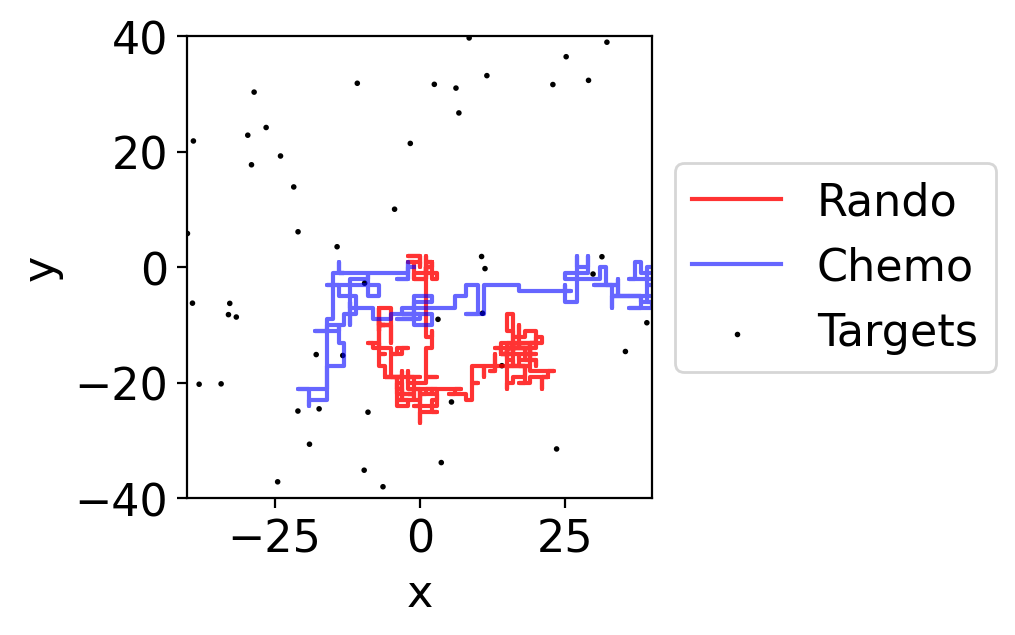

In [56]:
plot_boundary = target_boundary

# -
num_experiment = 2
ax = None
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Hard to distinguish their individual behaviors, but our agents seem to be exploring. It looks like this Chemo agent may be moving more than the Rando counterpart. So let's look at the overall distance both agents cover.


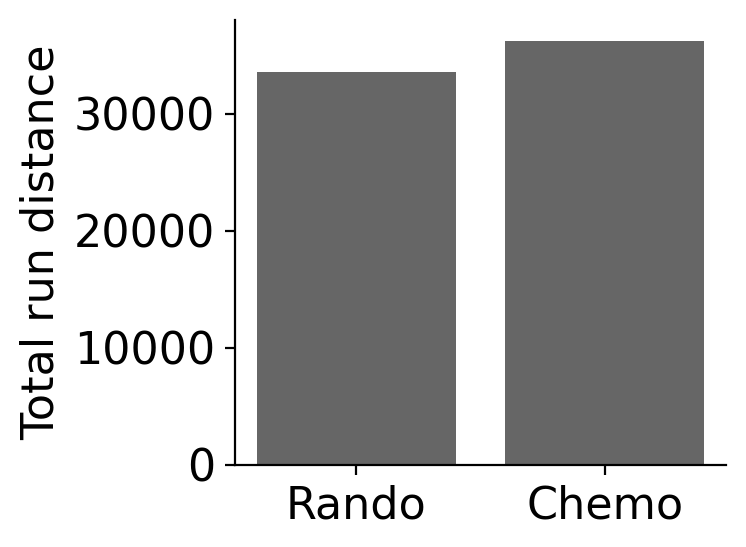

In [57]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["red", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += np.sum(r["agent_num_step"])
    scores.append(l)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.tight_layout()
sns.despine()

---
### Question 2.1

Why is the Chemo agent covering more distance than the random diffusion agent?

__Answer:__

The Chemo agent has has a greater step length, which is guided by scent to detect the signal rather than random Brownian motion.

Okay, now we can look at the overall performance of the two agents.

First, let's look at the most extreme performance measure: deaths. If an agent does not reach _at least one_ food pellet, then it dies at the end of the simulation. You've got to eat to survive afterall. Out of our set of simulations, how many deaths occured with each agent?

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

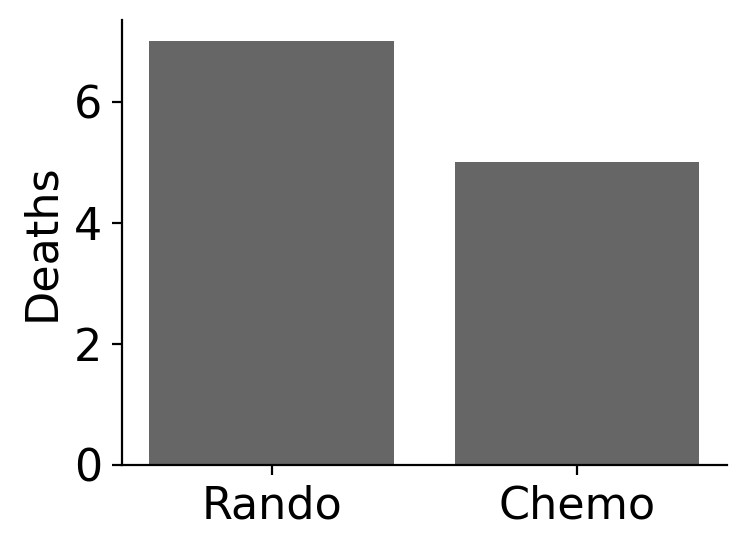

In [58]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["red", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

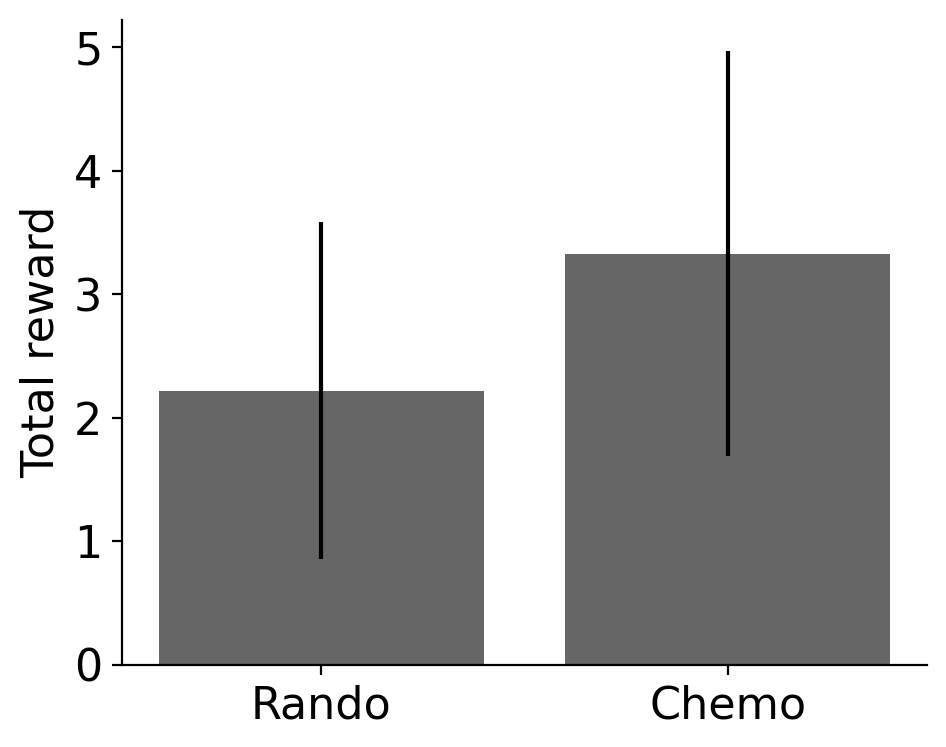

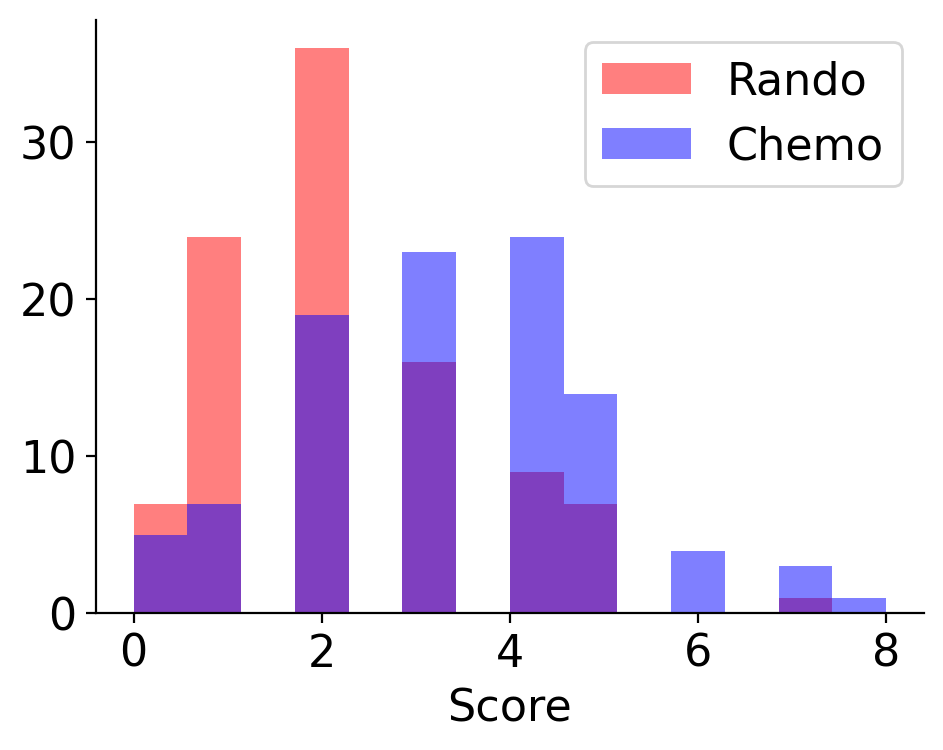

In [59]:
# Results
results = [rand_exp, chemo_exp]
names = ["Rando", "Chemo"]
colors = ["red", "blue"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 15))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 2.2

How do each of our agents perform across the performance measures we have chosen?

__Answer:__

There have been 7 deaths for Rando and 1 death for Chemo. Chemo has a total reward of more than 3 while Rando has a total reward of slightly above 2. Chemo is generally scoring higher than Rando.

---
### Question 2.3

What explains this difference in performance? Be specific.

__Answer:__

Rando is not collecting food as frequently as Chemo is. This is probably related to Chemo following the gradient and using the scent to find the signal. Chemo uses longer steps and travels further. Rando relies on random motion and has small steps and travels a shorter distance. This results in Chemo finding more targets and Rando dying from not finding as many targets.

---
### Question 2.4

Right now we have set _p neg_ and _p pos_ to 80% and 20% respectively. This means that the probability of stopping a run and tumbling is 80% of the time when a gradient is not increasing and 20% of the time when it is. Let's see how the performance changes when we make the algorithm almost deterministic. Write down the (approximate) performance numbers you have above (total run distance, number of deaths, and total reward), change _p neg_ to 1.00 and _p pos_ to 0.00. This means that whenever the gradient is increasing, our sniff valentino will keep running and when it decreases it will always tumble.

Wha the performance of our chemotaxic agent when you make this a deterministic algorithm? Why do you think this change in performance occured? Be specific.

__Answer:__

The total run distance for Rando is nearly 30,500 and nearly 40,500 for Chemo. The total number of deaths is 7 for Rando and 1 for Chemo. The total reweard is around 2 for Rando and around 3 for Chemo. This will change the performance. The run distance for Chemo is now around 30,500 with Rando remaining the same. Chemo now has a total number deaths of 5. The total reward for Chemo is between 3-4. I think this indicates a lower performance possibly because it will tumble 100% of the time the gradient is not increasing. It is traveling a shorter distance than it used to and not detecting the signal as well. Its accuracy has decreased as it tumbles more instead of running.  


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> Grace Swatsworth